In [42]:
from preamble import *
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Algorithm Chains and Pipelines

- Use the Pipeline class to simplify the process of building chains of transformations and models
- How we can combine Pipeline and GridSearchCV to search over parameters for all processing steps at one

Splitting the data, computing the mini‐ mum and maximum, scaling the data, and training the SVM:

In [3]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# load and split the data
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)

In [4]:
# rescale the training data
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)
# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.95


/Users/hsuningchang/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


### Parameter Selection with Preprocessing 

In [5]:
from sklearn.model_selection import GridSearchCV
# for illustration purposes only, don't use this code!
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Test set accuracy: {:.2f}".format(grid.score(X_test_scaled, y_test)))

Best cross-validation accuracy: 0.98
Best parameters:  {'C': 1, 'gamma': 1}
Test set accuracy: 0.97


We already used the information contained in the test part of the split, when scaling the data, as the test part in each split in the cross-validation is part of the training set. If we observe new data, this data will not have been used to scale the training data, and it might have a different minimum and maximum than the training data.

We already leaked information from theseparts of the data, this will lead to overly optimistic results during cross-validation, and possibly the selection of suboptimal parameters.

The splitting of the dataset during cross validation should be done before doing any preprocessing. **Any process that extracts knowledge from the dataset should only ever be applied to the training portion of the data set**, so any cross-validation should be the outermost loop in your processing.

Pipeline class can achieve this with the cross_val_score function and the GridSearchCV function. It is a class that allows gluing together multiple processing steps into a single sklearn estimator.

The Pipeline class itself has fit, predit, and score methods and behaves just like any other model in sklearn.

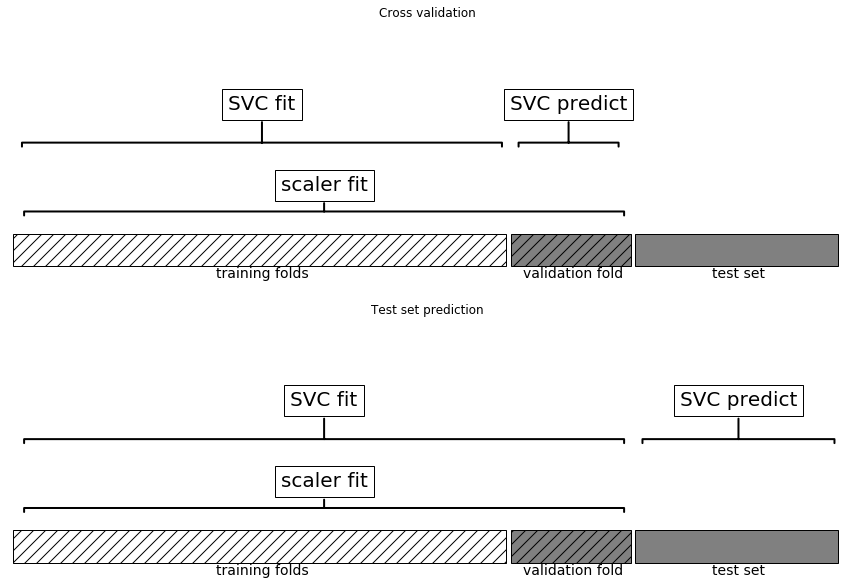

In [6]:
mglearn.plots.plot_improper_processing()

### Building Pipelines

First, we build a pipeline object by providing it with a list of steps. Each step is a tuple containing a name and an instance of an estimator.

In [7]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

Fit first calls fit on the scaler, then transforms the training data using the scaler, and finally fits the SVM with the scaled data.

In [8]:
pipe.fit(X_train, y_train)

/Users/hsuningchang/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('svm',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

Calling the score method first transforms the test data using the scaler, and then calls the score method on the SVM using the scaled test data.

In [9]:
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.95


### Using Pipelines in Grid-searches
We need to specify for each parameter which step of the pipeline it belongs to. Both parameters that we want to adjust are parameters of SVC, the second step. We gave this step the name "svm". The syntax to define a parameter grid for a pipeline is to specify for each parameter the step name, followed by _ (a double underscore), followed by the parameter name.

In [10]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [11]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


The MinMaxScaler is refit with only the training splits and no information is leaked from the test split into the parameter search.

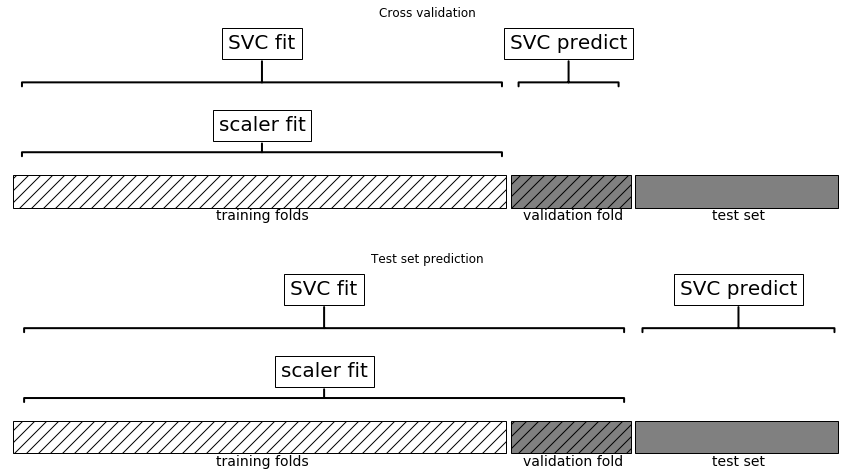

In [11]:
mglearn.plots.plot_proper_processing()

The impact of leaking information in the cross-validation varies depending on the nature of the preprocessing step. Estimating the scale of the data using the test fold usually doesn’t have a terrible impact, while using the test fold in feature extraction and feature selection can lead to substantial differences in outcomes.

### Illustrating Information Leakage


A synthetic regression task with 100 samples and 1000 features that are sampled independently from a Gaussian distribution. We also sample the response from a Gaussian distribution :

In [12]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

There is no relation between the data, X and the target y. It should not be possible to learn anything from this dataset.

Select the most informative of the 10 features using SelectPercentile feature selection, and then we evaluate a Ridge regressor using CV:

In [13]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape: {}".format(X_selected.shape))

X_selected.shape: (100, 500)


In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("Cross-validation accuracy (cv only on ridge): {:.2f}".format(
      np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

Cross-validation accuracy (cv only on ridge): 0.91


The mean R^2 indicating a very good model. This cannot be right as our data is entirely random. The feature selection picked out some features among the 10,000 random features that are very well correlated ith the target.

The information we leaked from the test folds was very informative, leading to highly unrealistic results.

In [15]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression,
                                             percentile=5)),
                 ("ridge", Ridge())])
print("Cross-validation accuracy (pipeline): {:.2f}".format(
      np.mean(cross_val_score(pipe, X, y, cv=5))))

Cross-validation accuracy (pipeline): -0.25


Using the pipe‐ line, the feature selection is now inside the cross-validation loop. This means features can only be selected using the training folds of the data, not the test fold. The feature selection finds features that are correlated with the target on the training set, but because the data is entirely random, these features are not correlated with the target on the test set.

Rectifying the data leakage issue in the feature selec‐ tion makes the difference between concluding that a model works very well and con‐ cluding that a model works not at all.

### The General Pipeline Interface
The Pipelin class can in fact join anyr number of estimators together.

For example, you could build a pipeline containing feature extraction, feature selection, scaling, and classification, for a total of four steps. Similarly, the last step could be regression or clustering instead of classification. The only requirement for estimators is that the last step need to have a transform method to produce a new representation of the data that can be used in the next step.

Internally, during the call to Pipeline.fit, the pipeline calls fit and then transform on each step in turn, ith the input given by the output of the transform method of the previous step.

The pipeline.steps is a list of tuples, so pipeline.steps[0][1] is the first estimator, pipeline.steps[1][1] is the second estimator, and so on.

In [27]:
pipe.steps

[('select', SelectPercentile(percentile=5,
                   score_func=<function f_regression at 0x1c17f1c9e0>)),
 ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
        normalize=False, random_state=None, solver='auto', tol=0.001))]

In [28]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # iterate over all but the final step
        # fit and transform the data
        X_transformed = estimator.fit_transform(X_transformed, y)
    # fit the last step
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [29]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # iterate over all but the final step
        # transform the data
        X_transformed = step[1].transform(X_transformed)
    # predict using the last step
    return self.steps[-1][1].predict(X_transformed)

![pipeline_illustration](images/pipeline.png)

The pipeline is actually even more general than this. There is no requirement for the last step in a pipeline to have a predict function, and we could create a pipeline just containing, for example, a scaler and PCA. Then, because the last step (PCA) has a transform method, we could call transform on the pipeline to get the output of PCA.transform applied to the data that was processed by the previous step. The last step of a pipeline is only required to have a fit method.

### Convenient Pipeline creation with ``make_pipeline``
A convenience function make!pipeline that will create a pipeline for us and automatically name each step based ont its class.

In [30]:
from sklearn.pipeline import make_pipeline
# standard syntax
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [31]:
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False))]


In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("Pipeline steps:\n{}".format(pipe.steps))

Pipeline steps:
[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


#### Accessing step attributes
Often you will want to inspect attributes of one of the steps of the pipeline—say, the coefficients of a linear model or the components extracted by PCA. The easiest way to access the steps in a pipeline is via the named_steps attribute, which is a dictionary from the step names to the estimators:

In [33]:
# fit the pipeline defined before to the cancer dataset
pipe.fit(cancer.data)
# extract the first two principal components from the "pca" step
components = pipe.named_steps["pca"].components_
print("components.shape: {}".format(components.shape))

components.shape: (2, 30)


#### Accessing Attributes in a Pipeline inside GridSearchCV


In [38]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [39]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                     

In [44]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


In [45]:
print("Logistic regression step:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"]))

Logistic regression step:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [46]:
print("Logistic regression coefficients:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"].coef_))

Logistic regression coefficients:
[[-0.391 -0.39  -0.377 -0.382 -0.126  0.015 -0.338 -0.379 -0.051  0.229
  -0.476  0.006 -0.35  -0.355 -0.03   0.194 -0.005 -0.078  0.235  0.231
  -0.54  -0.536 -0.492 -0.489 -0.391 -0.13  -0.393 -0.424 -0.33  -0.136]]


### Grid-searching preprocessing steps and model parameters
Another benefit of Pipeline is that we can now **adjust the parameters of the preprocessing using the outcome of a supervised task** like regression or classification.

In previous chapters, we used polynomial fea‐ tures on the boston dataset before applying the ridge regressor. Let’s model that using a pipeline instead. The pipeline contains three steps—scaling the data, computing polynomial features, and ridge regression:

In [47]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

How do we know which degrees of polynomials to choose, or whether to choose any polynomials or interactions at all? Ideally we want to select the degree parameter based on the outcome of the classification. Using our pipeline, we can search over the degree parameter together with the parameter alpha of Ridge. To do this, we define a param_grid that contains both, appropriately prefixed by the step names:

In [48]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [49]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
         

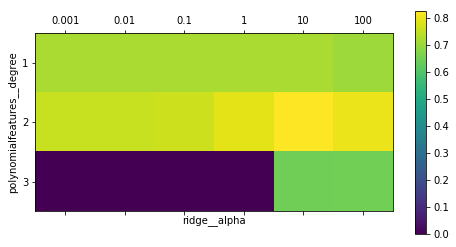

In [59]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1), vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
param_grid['polynomialfeatures__degree']) 
plt.colorbar()

In [60]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [61]:
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Test-set score: 0.77


In [62]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Score without poly features: {:.2f}".format(grid.score(X_test, y_test)))

Score without poly features: 0.63


### Grid-Searching Which Model To Use
It is also possible to search overt he actual steps being performed in the pipeline, like whether to use StandardScaler or MinMaxScaler.

This leads to an even bigger search space and should be considered carefully.

Here, we explicitly name the steps. We want two steps, one for the preprocessing and then a classifier. We can instantiate this using SVC and StandardScaler:

In [63]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

- We want the classifier to be either RandomForestClassifier or SVC
- When we wanted to skip a step in the pipeline (for example, because we don’t need preprocessing for the RandomForest), we can set that step to None

In [66]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best cross-validation score: 0.99
Test-set score: 0.98


#### Avoiding Redundant Computation

memory : str or object with the joblib.Memory interface, default=None

    Used to cache the fitted transformers of the pipeline. By default, no caching is performed. If a string is given, it is the path to the caching directory. Enabling caching triggers a clone of the transformers before fitting. Therefore, the transformer instance given to the pipeline cannot be inspected directly. Use the attribute named_steps or steps to inspect estimators within the pipeline. Caching the transformers is advantageous when fitting is time consuming.


We can set ‘memory’ as the directory path where to cache the transformers or it can be a joblib.Memory object. Below, I am using the current directory as the cache directory where all the cache objects for the transformer would be created.

In [68]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())],
                memory=".")

### Summary and Outlook
- Pipeline class is a general-purpose tool to chain together multiple processing steps in a machine learning workflow
- Using pipelines allows us to encapsulate multiple steps into a single Pyhon object that adheres to the familiar scikit-learn interface of fit, predict, and transform.
- It can capture all the processing steps when doing model evaluation using cross-validation and parameter selection using grid search
- The pipeline class allows writing more succinct code, and reduces the likelihood of mistakes that can happen when building processing chains without the pipeline class (like forgetting to apply all transformers on the test set, and right order)
- Chossing the right combination of feature extraction, preprocessing, and models is somewhat of an art, and often requires some trial and error. Using pipelines makes the trying out of many steps is quite simple
- Be careful not to overcomplicate your processes, and make sure to evaluate whether every component you are including in your model is necessary
